# ViT vs CNN

In [1]:
import glob
from typing import List

import BiT
from ViT import modeling as ViT

from PIL import Image
from PIL.Image import Image as Img
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np

import torch.nn as nn
import torchvision.transforms as T

In [2]:
dataset_path = 'data/cats'

In [3]:
def get_weights(path):
  return np.load(path)

## Prepare dataset and model

In [4]:
IMG_SIZE = (384, 384)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [5]:
def load_images(dataset_path: str) -> List[Img]:
    images = []
    for filename in glob.glob(dataset_path + '/*.jpg'):
        im=Image.open(filename).convert('RGB')
        images.append(im)
    return images


def load_vit(model_name='ViT-B_16', path='ViT-B_16.npz') -> nn.Module:
    config = ViT.CONFIGS[model_name]
    model = ViT.VisionTransformer(config, num_classes=1000, img_size=384)
    model.load_from(get_weights(path))
    return model.eval()

def load_bit(model_name='BiT-M-R50x3', path='BiT-M-R50x3-ILSVRC2012.npz') -> nn.Module:
    model = BiT.KNOWN_MODELS[model_name](head_size=1000)
    model.load_from(get_weights(path))
    return model

In [6]:
images = load_images(dataset_path)
vit = load_vit()
bit = load_bit()

## Compare predictions

In [7]:
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

In [8]:
def show_predictions(img, vit_predictions, bit_predictions):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(nrows=3, ncols=2)

    ax0 = fig.add_subplot(gs[1, 0])
    ax0.axis("off")
    ax0.invert_yaxis()
    ax0.text(0.1, 0.25, bit_predictions, verticalalignment="center")
    ax0.set_title("BiT prediction")

    ax1 = fig.add_subplot(gs[2, 0])
    ax1.axis("off")
    ax1.invert_yaxis()
    ax1.text(0.1, 0.25, vit_predictions, verticalalignment="center")
    ax1.set_title("ViT prediction")

    ax2 = fig.add_subplot(gs[:, 1])
    ax2.imshow(img)
    ax2.axis("off")
    
    plt.tight_layout()
    plt.show()

In [9]:
def show_predictions_comp(img,
        vit_predictions_default, vit_predictions_new, 
        bit_predictions_default, bit_predictions_new):
    
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(nrows=3, ncols=3)

    ax0 = fig.add_subplot(gs[1, 0])
    ax0.axis("off")
    ax0.invert_yaxis()
    ax0.text(0.1, 0.25, bit_predictions_default, verticalalignment="center")
    ax0.set_title("BiT default prediction")

    ax1 = fig.add_subplot(gs[2, 0])
    ax1.axis("off")
    ax1.invert_yaxis()
    ax1.text(0.1, 0.25, vit_predictions_default, verticalalignment="center")
    ax1.set_title("ViT default prediction")
    
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.axis("off")
    ax2.invert_yaxis()
    ax2.text(0.1, 0.25, bit_predictions_new, verticalalignment="center")
    ax2.set_title("BiT new prediction")

    ax3 = fig.add_subplot(gs[2, 1])
    ax3.axis("off")
    ax3.invert_yaxis()
    ax3.text(0.1, 0.25, vit_predictions_new, verticalalignment="center")
    ax3.set_title("ViT new prediction")

    ax4 = fig.add_subplot(gs[:, 2])
    ax4.imshow(img)
    ax4.axis("off")
    
    plt.tight_layout()
    plt.show()

In [10]:
no_pred = 3

def prediction(img):
    img_tensor = transforms(img).unsqueeze(0)

    out_vit = vit(img_tensor)
    out_bit = bit(img_tensor)

    vit_predictions = [imagenet_labels[int(i)] for i in np.argsort(out_vit[0].detach().numpy())[0]]
    bit_predictions = [imagenet_labels[int(i)] for i in np.argsort(out_bit.detach().numpy())[0]]

    vit_predictions = ''.join(str(e) for e in vit_predictions[-no_pred:])
    bit_predictions = ''.join(str(e) for e in bit_predictions[-no_pred:])

    show_predictions(img, vit_predictions, bit_predictions)

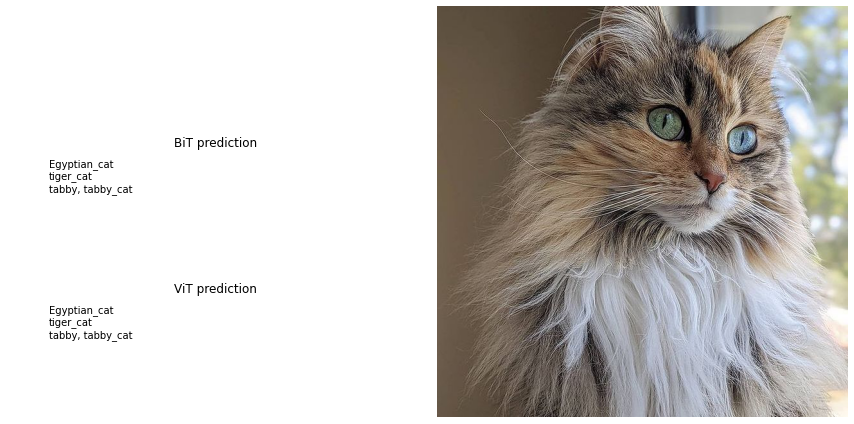

In [11]:
prediction(images[2])

In [12]:
from ipynb.fs.full.perturb_dataset import *

In [13]:
MASK = {
    'BlackBoxMasking_1': BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128))),
    'BlackBoxMasking_2': BlackBoxMasking(layout=FixedLayout(masks=[(0.4, 0.4, 0.6, 0.6)])),
    'BlackBoxMasking_3': BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30)),
    'BlackBoxMasking_4': BlackBoxMasking(layout=GridLayout(perc=0.2, grid_size=8)),
    'MedianMasking' : MedianMasking(layout=FixedShapeLayout(count=30, shape=(32,32))),
    'BlurMasking_1': BlurMasking(layout=FixedShapeLayout(count=5, shape=(100, 100)), blur=16),
    'BlurMasking_2': BlurMasking(layout=GridLayout(perc=0.7, grid_size=8), blur=16),
}

In [14]:
def predict_and_comp(img, mask_id='BlackBoxMasking_1'):
    img_mod = MASK[mask_id](img)
    
    img_tensor = transforms(img).unsqueeze(0)
    out_vit = vit(img_tensor)
    out_bit = bit(img_tensor)
    
    img_tensor = transforms(img_mod).unsqueeze(0)
    out_vit_mod = vit(img_tensor)
    out_bit_mod = bit(img_tensor)

    vit_predictions = [imagenet_labels[int(i)] for i in np.argsort(out_vit[0].detach().numpy())[0]]
    bit_predictions = [imagenet_labels[int(i)] for i in np.argsort(out_bit.detach().numpy())[0]]
    vit_predictions_mod = [imagenet_labels[int(i)] for i in np.argsort(out_vit_mod[0].detach().numpy())[0]]
    bit_predictions_mod = [imagenet_labels[int(i)] for i in np.argsort(out_bit_mod.detach().numpy())[0]]

    vit_predictions = ''.join(str(e) for e in vit_predictions[-no_pred:])
    bit_predictions = ''.join(str(e) for e in bit_predictions[-no_pred:])
    vit_predictions_mod = ''.join(str(e) for e in vit_predictions_mod[-no_pred:])
    bit_predictions_mod = ''.join(str(e) for e in bit_predictions_mod[-no_pred:])

    show_predictions_comp(img_mod, vit_predictions, vit_predictions_mod, bit_predictions, bit_predictions_mod)

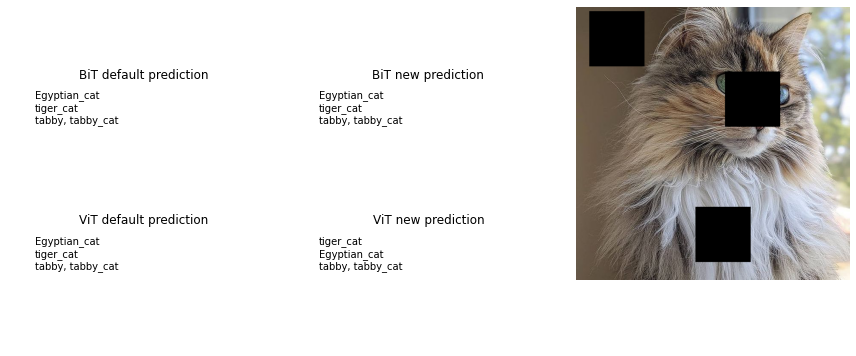

In [15]:
predict_and_comp(images[2])

## Compare activation maps

In [ ]:
# TODO

## Compare embeddings clusters

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

In [ ]:
def draw_clustering(embeddings, n_clusters, r=1.5):
    clustering = AgglomerativeClustering(n_clusters).fit(np.array(embeddings))
    colors = [np.random.rand(3,) for _ in range(n_clusters)]
    labels = clustering.labels_
    embeddings_2d = MDS().fit_transform(embeddings)
    
    fig, ax = plt.subplots(figsize=(17, 17))
    
    for i in range(embeddings_2d.shape[0]):
        im = OffsetImage(images[i], zoom=0.1)
        ab = AnnotationBbox(im, embeddings_2d[i], xycoords='data', frameon=False)
        ax.add_artist(ab)

    for i in range(n_clusters):
        index = labels == i
        points = []
        for pt in embeddings_2d[index]:
            points.append(pt)
            points.append(pt + np.array((1, 1)) * r)
            points.append(pt + np.array((1, -1)) * r)
            points.append(pt + np.array((-1, 1)) * r)
            points.append(pt + np.array((-1, -1)) * r)
        points = np.array(points)
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        x_hull = np.append(hull_points[:, 0], hull_points[:, 0][0])
        y_hull = np.append(hull_points[:, 1], hull_points[:, 1][0])
        plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])
        
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    plt.show()

In [ ]:
images = images
img_tensors = [transforms(img).unsqueeze(0) for img in images]
img_batch = torch.cat(img_tensors)
assert img_batch.shape[0] > 1

In [ ]:
with torch.no_grad():
    vit_embeddings = vit.transformer(img_batch)[0][:, 0, :]

In [ ]:
base = list(bit.children())[:-1]
pooling = list(bit.head.children())[:-1]
bit_pruned = nn.Sequential(*base, *pooling)
with torch.no_grad():
    bit_embeddings = bit_pruned(img_batch).squeeze()

In [ ]:
draw_clustering(vit_embeddings, 8)

In [ ]:
draw_clustering(bit_embeddings, 8, r=8)